In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [6]:
code_directory = '/Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/code'
os.chdir(code_directory)

# set the paths relative to this new current directory
base_path_data = '../Data'
results_path = '../results'
hup_region_features = pd.read_csv(os.path.join(results_path, 'ge_go_hup_region_features.csv'))
mni_region_features = pd.read_csv(os.path.join(results_path, 'mni_region_features.csv'))

# Add 'site' column
hup_region_features['site'] = 'HUP'
mni_region_features['site'] = 'MNI'

In [7]:
# Combine datasets
region_features = pd.concat([hup_region_features, mni_region_features], ignore_index=True)

# List of feature columns
feature_columns = ['deltaRel_mean', 'thetaRel_mean', 'alphaRel_mean', 'betaRel_mean', 'gammaRel_mean', 'entropy_1min_mean', 'entropy_fullts_mean']

# Aggregate features per patient
patient_features = region_features.groupby(['patient_id', 'site'])[feature_columns].mean().reset_index()

# Feature matrix X and labels y
X = patient_features[feature_columns]
y = patient_features['site'].map({'HUP': 1, 'MNI': 0})

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42)

Logistic Regression - torch

In [8]:
# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create DataLoader for training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [9]:
# Define logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        logits = self.linear(x)
        probas = torch.sigmoid(logits)
        return probas

In [10]:
input_dim = X_train_tensor.shape[1]
model = LogisticRegressionModel(input_dim)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
# training loop

num_epochs = 100  # Adjust as needed

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    epoch_loss /= len(train_loader.dataset)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 10/100, Loss: 0.5728
Epoch 20/100, Loss: 0.5495
Epoch 30/100, Loss: 0.5301
Epoch 40/100, Loss: 0.5135
Epoch 50/100, Loss: 0.4989
Epoch 60/100, Loss: 0.4858
Epoch 70/100, Loss: 0.4740
Epoch 80/100, Loss: 0.4634
Epoch 90/100, Loss: 0.4536
Epoch 100/100, Loss: 0.4449


In [13]:
model.eval()
with torch.no_grad():
    # Training data predictions
    train_outputs = model(X_train_tensor)
    train_preds = (train_outputs >= 0.5).float()
    train_accuracy = (train_preds == y_train_tensor).float().mean()
    print(f'Training Accuracy: {train_accuracy.item():.4f}')

    # Test data predictions
    test_outputs = model(X_test_tensor)
    test_preds = (test_outputs >= 0.5).float()
    test_accuracy = (test_preds == y_test_tensor).float().mean()
    print(f'Test Accuracy: {test_accuracy.item():.4f}')

Training Accuracy: 0.8318
Test Accuracy: 0.6296


In [14]:
# Convert tensors to numpy arrays
y_test_np = y_test_tensor.numpy()
test_outputs_np = test_outputs.numpy()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_np, test_outputs_np)
roc_auc = auc(fpr, tpr)

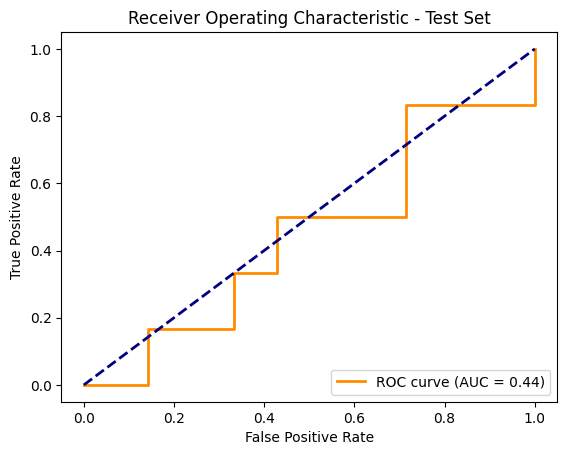

Confusion Matrix:
[[16  5]
 [ 5  1]]
Classification Report:
              precision    recall  f1-score   support

         MNI       0.76      0.76      0.76        21
         HUP       0.17      0.17      0.17         6

    accuracy                           0.63        27
   macro avg       0.46      0.46      0.46        27
weighted avg       0.63      0.63      0.63        27



In [16]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
test_preds_np = test_preds.numpy()
conf_matrix = confusion_matrix(y_test_np, test_preds_np)
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report
print('Classification Report:')
print(classification_report(y_test_np, test_preds_np, target_names=['MNI', 'HUP']))

Logistic regression, random forest classifier, and SVM (sklearn)

In [18]:
def prepare_data(hup_features, mni_features, feature_columns):
    # Aggregate features per patient
    hup_patient_features = hup_features.groupby('patient_id')[feature_columns].mean()
    mni_patient_features = mni_features.groupby('patient_id')[feature_columns].mean()
    
    # Create labels
    hup_labels = np.ones(len(hup_patient_features))
    mni_labels = np.zeros(len(mni_patient_features))
    
    X = np.vstack([hup_patient_features.values, mni_patient_features.values])
    y = np.hstack([hup_labels, mni_labels])
    
    return X, y

def train_evaluate_model(X, y, model_type='logistic'):
    """Train and evaluate model with cross-validation"""
    scaler = StandardScaler()
    
    # Define models and parameters
    models = {
        'logistic': (LogisticRegression(), {
            'C': [0.1, 1.0, 10.0],
            'class_weight': ['balanced', None]
        }),
        'rf': (RandomForestClassifier(), {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, None],
            'class_weight': ['balanced', None]
        }),
        'svm': (SVC(probability=True), {
            'C': [0.1, 1.0, 10.0],
            'kernel': ['linear', 'rbf'],
            'class_weight': ['balanced', None]
        })
    }
    
    model, param_grid = models[model_type]
    
    # Cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(
        model, param_grid, 
        cv=cv, scoring='roc_auc',
        n_jobs=-1
    )
    
    # Scale features
    X_scaled = scaler.fit_transform(X)
    
    # Fit grid search
    grid_search.fit(X_scaled, y)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
    
    # Get feature importances for interpretability
    if model_type == 'logistic':
        importances = pd.Series(
            grid_search.best_estimator_.coef_[0],
            index=feature_columns
        ).sort_values(ascending=False)
        print("\nFeature Importances:")
        print(importances)
    
    return grid_search.best_estimator_, scaler

def plot_results(model, X_scaled, y):
    """Plot ROC curve and confusion matrix"""
    y_pred_proba = model.predict_proba(X_scaled)[:, 1]
    y_pred = model.predict(X_scaled)
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    
    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    plt.subplot(1, 2, 2)
    plt.imshow(cm, cmap='Blues')
    plt.colorbar()
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(y, y_pred, target_names=['MNI', 'HUP']))

Best parameters: {'C': 1.0, 'class_weight': 'balanced'}
Best cross-validation score: 0.725

Feature Importances:
gammaRel_mean          0.925539
deltaRel_mean          0.778367
entropy_1min_mean      0.457452
entropy_fullts_mean    0.452367
alphaRel_mean          0.229371
thetaRel_mean         -0.226933
betaRel_mean          -0.595044
dtype: float64


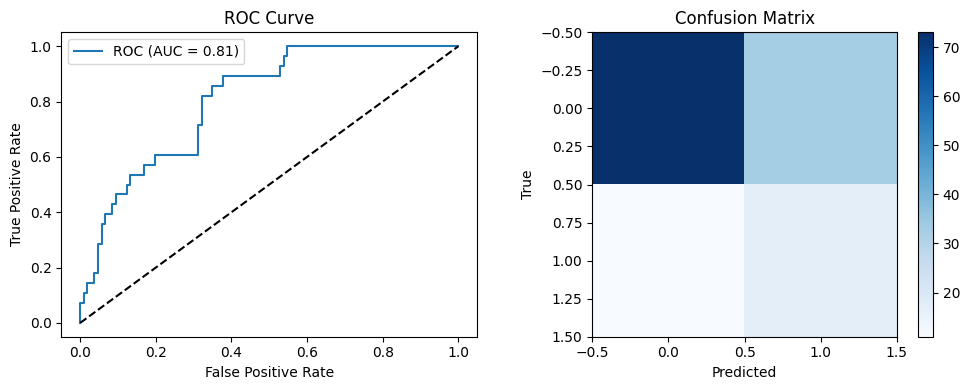


Classification Report:
              precision    recall  f1-score   support

         MNI       0.87      0.69      0.77       106
         HUP       0.34      0.61      0.44        28

    accuracy                           0.67       134
   macro avg       0.60      0.65      0.60       134
weighted avg       0.76      0.67      0.70       134



In [19]:
# logistic
model, scaler = train_evaluate_model(X, y, model_type='logistic')
plot_results(model, scaler.transform(X), y)

Best parameters: {'class_weight': 'balanced', 'max_depth': 3, 'n_estimators': 200}
Best cross-validation score: 0.769


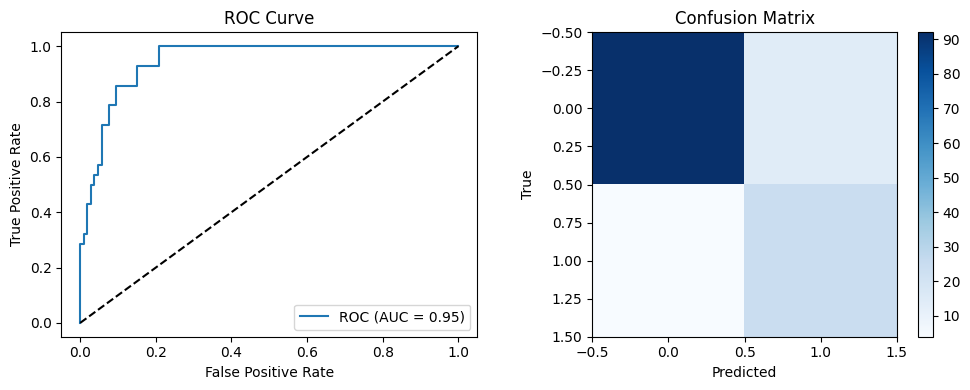


Classification Report:
              precision    recall  f1-score   support

         MNI       0.96      0.87      0.91       106
         HUP       0.63      0.86      0.73        28

    accuracy                           0.87       134
   macro avg       0.79      0.86      0.82       134
weighted avg       0.89      0.87      0.87       134



In [20]:
model, scaler = train_evaluate_model(X, y, model_type='rf')
plot_results(model, scaler.transform(X), y)

Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'rbf'}
Best cross-validation score: 0.752


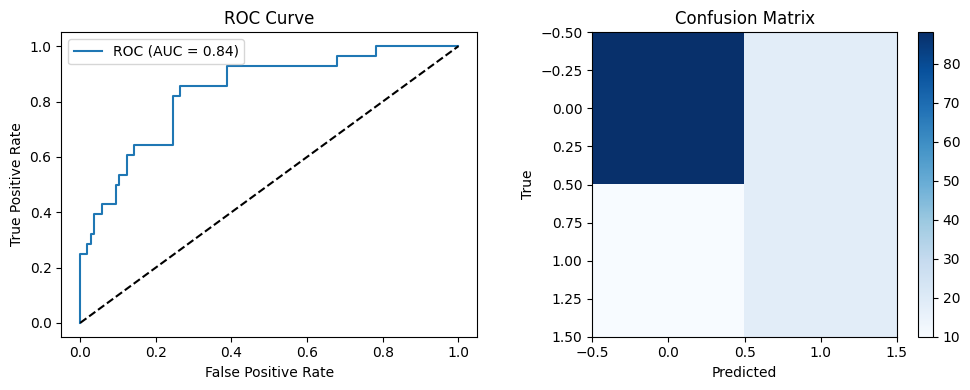


Classification Report:
              precision    recall  f1-score   support

         MNI       0.90      0.83      0.86       106
         HUP       0.50      0.64      0.56        28

    accuracy                           0.79       134
   macro avg       0.70      0.74      0.71       134
weighted avg       0.81      0.79      0.80       134



In [21]:
model, scaler = train_evaluate_model(X, y, model_type='svm')
plot_results(model, scaler.transform(X), y)